In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.3'
           
import matplotlib.pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle,resample
from sklearn.linear_model import Ridge


import jax
from jax import random, numpy as jnp
from flax.core import freeze, unfreeze

import sys
sys.path.append('../../pdeX')
from DeepModx import pdeX

from time import time

%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pickle

In [3]:
sns.set(font_scale=1.5)
sns.set_style("white")


# Loading data

In [4]:
nn_shared_features = []
nn_specific_features = [65,65,65,65,1]


noise_level = 0.4
number_of_samples=2000


'nBurgers'+str(number_of_samples)+'_'+str(int(noise_level*100))

x     = np.load('../../data/burgers_x'+'_'+str(number_of_samples)+'.npy')
t     = np.load('../../data/burgers_t'+'_'+str(number_of_samples)+'.npy')

u     = np.array(np.load('../../data/burgers_u'+'_'+str(number_of_samples)+'.npy'),dtype=np.float32).reshape(len(x),len(t))
u     = u + noise_level*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

nx = 200
nt = 200



#X_train = np.load('X_train.npy')

In [5]:
a_file = open("new_params.pkl", "rb")
new_params = pickle.load(a_file)

a_file = open("state.pkl", "rb")
new_state = pickle.load(a_file)

scale_from_outputs = np.load('scale_from_outputs.npy')

## auxiliary function

In [6]:

def X_new(nx,nt):
    tmax = t.max()
    xmax = x.max()
    x1 = jnp.linspace(x.min(), x.max(), nx)
    t1 = jnp.linspace(t.min(), t.max(), nt)    
    t_grid, x_grid = jnp.meshgrid(t1, x1, indexing="ij")
    Xnn = jnp.concatenate([(t_grid/tmax).reshape(-1, 1), (x_grid/xmax).reshape(-1, 1)], axis=1)

    return Xnn

# rebuilding NN

In [7]:
model = pdeX(nn_shared_features, nn_specific_features, 1)
variables = model.init(random.PRNGKey(42), X_new(nx,nt))

In [8]:
state, params = variables.pop('params')

In [9]:
new_variables = freeze({'params': new_params, **new_state})

In [10]:
uu1 = model.apply(new_variables, X_new(nx,nt), mutable=list(state.keys()))
uu = uu1[0][0].reshape(nt,nx)

In [11]:
uu1[0][0].shape

(40000, 1)

In [12]:
theta = uu1[0][2][0]

# Plots

In [13]:
idx = resample(np.arange((u.ravel()).shape[0]),replace=False,random_state=0,n_samples=number_of_samples)
# recasting for plots    
u_sbv = -1000 * np.ones(u.shape).ravel()
u_sbv[idx] = u.ravel()[idx]
u_sb = u_sbv.reshape(u.shape)


[]

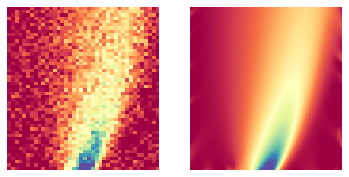

In [14]:
fig,ax = plt.subplots(1,2, figsize=(6,3))

bx = sns.heatmap(u.T,ax=ax[0],vmin=0,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

bx = sns.heatmap(uu*scale_from_outputs,ax=ax[1],vmin=0,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

#plt.savefig("../../figures/burgers10.png", bbox_inches='tight')

In [15]:
np.save('data_input',u.T)
np.save('recovered',uu*scale_from_outputs)